# Transfer Learning Deep Autoencoders (TLDA)

In [28]:
# preparation
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt


This is an implementation practice of TLDA. TLDA is proposed by Zhuang et al. to address issues of what previous feature trasnfer learning methods have neglected.
1. Previous methods did not explicitly minimized the distance between domains.
2. Due to the approch with unsupervised learning, no discriminative information is encoded.

TLDA is a supervised learning with deep encoder which means it requires label to train the model unlike the usual autoencoders.

## Model

The model is composed of two econding and decoding layers respectively. Encoding layers consist of _embedding layer_ and _label encoding layer_. By minimizing distance of source embedding layer and target embedding layer with KL divergence, the model enforces two domains to share the features. Also, by making label encoding layer to act as if classification layer, model contains discriminative information for source domain as well.

In [29]:
class TLDA(nn.Module):
    def __init__(self, inp_sz, emb_sz, cls_sz):
        super().__init__()
        self.enc_emb = nn.Sequential(nn.Linear(inp_sz, emb_sz), nn.Sigmoid())
        self.enc_lb = nn.Sequential(nn.Linear(emb_sz, cls_sz), nn.Sigmoid())
        self.dec_lb = nn.Sequential(nn.Linear(cls_sz, emb_sz), nn.Sigmoid())
        self.dec_emb = nn.Sequential(nn.Linear(emb_sz, inp_sz), nn.Sigmoid())

    def forward(self, src_inp, tgt_inp):
        # TLDA takes data from source and target separately
        # because they take parts in loss function differently

        src_inp  = src_inp.view(-1, 784)    # Shape B x 1 x 28 x 28 to Shape B x 784
        tgt_inp  = tgt_inp.view(-1, 784)    # Shape B x 1 x 28 x 28 to Shape B x 784
        
        src_emb = self.enc_emb(src_inp)
        src_pred = self.enc_lb(src_emb)
        src_opt = self.dec_lb(src_pred)
        src_opt = self.dec_emb(src_opt)

        tgt_emb = self.enc_emb(tgt_inp)
        tgt_opt = self.enc_lb(tgt_emb)
        tgt_opt = self.dec_lb(tgt_opt)
        tgt_opt = self.dec_emb(tgt_opt)

        return src_emb, tgt_emb, src_opt, tgt_opt, src_pred

model = TLDA(784, 10, 2)

Let's visualize the graph with tensorboard.
We see two tensors only passing through the embedding layer and the last two passing through the entire deep autoencoder, so the graph looks correct

In [30]:
from torch.utils.tensorboard import SummaryWriter

dummy_src_inp = torch.ones(1, 1, 28, 28)
dummy_tgt_inp = torch.ones(1, 1, 28, 28)

writer = SummaryWriter()
writer.add_graph(model, (dummy_src_inp, dummy_tgt_inp))
writer.close()

# %load_ext tensorboard
# %tensorboard --logdir=runs

## Loss Function

The loss function of TDLA is unique to other autoencoders. There are four components into it.
1. Minimizing reconstruction error with MSE
2. Minimizing distribution distance with KL divergence
3. Acquiring distinctive information with softmax regression (Cross Entropy Loss)
4. Regularization

Thus, the loss function looks like the following,

$$ Loss = J_r(x, \hat{x}) + \alpha\Gamma(\xi^{(s)}, \xi^{(t)}) + \beta\mathcal{L}(\theta, \xi^{(s)}) + \gamma\Omega(W, b, W', b') $$ 
For the further detail, please refer to the original paper.

In [31]:
def rec_err(src_inp, tgt_inp, src_opt, tgt_opt):
    # stack src and tgt in column wise so that shape (B_s+B_t) x 784
    inp = torch.cat((src_inp, tgt_inp), 0).view(-1, 784)
    opt = torch.cat((src_opt, tgt_opt), 0)
    # return (inp - opt).square().sum()     # the value is too big, let's do MSE
    fn = nn.MSELoss()
    return fn(inp, opt)
    

def dist_diff(src_emb, tgt_emb):
    # elm values need to be all positive meaning sigmoid
    # assume shape B x E
    P_s = src_emb.mean(0)
    P_t = tgt_emb.mean(0)
    P_s = (P_s / P_s.sum()).log()
    P_t = (P_t / P_t.sum()).log()
    fn = torch.nn.KLDivLoss(log_target=True)
    return fn(P_s, P_t) + fn(P_t, P_s)  # make symmetrical
    

def pred_err(src_pred, src_lb):
    src_pred = src_pred.view(-1, 2)
    fn = torch.nn.CrossEntropyLoss()
    return fn(src_pred, src_lb)

def reg(W1, b1, W2, b2):
    # likewise, sqrt to manageable value
    return (W1.square().sum() + b1.square().sum() + W2.square().sum() + b2.square().sum()).sqrt()

In [32]:
# loss function test
src_inp = torch.randn((4, 784))
tgt_inp = torch.randn((2, 784))

src_opt = torch.randn((4, 784))
tgt_opt = torch.randn((2, 784))

src_emb, tgt_emb = torch.randn(4, 5), torch.randn(2, 5)
src_emb = src_emb * torch.sign(src_emb)
tgt_emb = tgt_emb * torch.sign(tgt_emb)

src_lb = torch.randint(0, 2, (4,))

print('rec_err:', rec_err(src_inp, tgt_inp, src_opt, tgt_opt))
print('dist_diff:', dist_diff(src_emb, tgt_emb))
# print('pred_err:', pred_err(src_inp, src_lb))


rec_err: tensor(1.9968)
dist_diff: tensor(0.0213)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


## Data

We will use MNIST number data to explore performance of TLDA.
For the sake of simplicity, it will be a binary classificatio task, and labels will be divided into positive and negative after two domains from dataset is picked.
For instance, we pick data that are labeled as one and two, and one and three. Then information gained from the first subset will help to classify second subset.

For the baseline, we will train DNN shaped same as an encoder with data from source domain and use the parameters trained to predict data from target domain.

In [33]:
class SubMNIST(Dataset):
    def __init__(self, dataset, pos_idx, neg_idx):
        self.dataset = dataset
        self.mapping = {
            pos_idx: 0,
            neg_idx: 1
        }
        self.sub_dataset = self.subset(pos_idx, neg_idx)
        
    
    def subset(self, pos_idx, neg_idx):
        return [(data[0], self.mapping[data[1]]) for data in self.dataset if data[1] in [pos_idx, neg_idx]]
    
    def __len__(self):
        return len(self.sub_dataset)

    def __getitem__(self, idx):
        return self.sub_dataset[idx]

        


transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
src_dataset = SubMNIST(train_dataset, 8, 5)     # use info from binary classfication of 1 and 2
tgt_dataset = SubMNIST(train_dataset, 8, 1)     # to help classify 1 and 3

num_batch = 100     # set the number of batches for both source and target domains

src_loader = DataLoader(src_dataset, batch_size=len(src_dataset) // num_batch, # note that batch_size varies
                        shuffle=True, drop_last=True)
tgt_loader = DataLoader(tgt_dataset, batch_size=len(tgt_dataset) // num_batch,
                        shuffle=True, drop_last=True)


## Train

For the memory efficiency, I trained with mini-batch using Adam optimizer. Each batch will contain some number of labeled data from source domain and unlabeled data from target domain. Remember TLDA is a supervised learning method, and only the label from source domain will take part in the loss function.


In [34]:
model = TLDA(784, 10, 2)

lr = 0.001
epochs = 50
alpha = 0.01     # Different than what is suggested in the paper
beta = 0.01
gamma = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr)
losses = []
def train():
    for epoch in range(epochs):
        total_loss = 0
        cur_time = time.time()
        for batch_i, sampled_batch in enumerate(zip(src_loader, tgt_loader)):
            src, tgt = sampled_batch
            src_imgs, src_lbs = src
            tgt_imgs, _ = tgt     # target labels won't be used

            optimizer.zero_grad()
            src_emb, tgt_emb, src_opt, tgt_opt, src_pred = model(src_imgs, tgt_imgs)
            param = model.state_dict()
            loss = rec_err(src_imgs, tgt_imgs, src_opt, tgt_opt)\
                   + alpha * dist_diff(src_emb, tgt_emb)\
                   + beta * pred_err(src_pred, src_lbs)\
                   + gamma * reg(model.enc_emb[0].weight, model.enc_emb[0].bias, 
                         model.enc_lb[0].weight, model.enc_lb[0].bias)
            loss.backward()
            optimizer.step()
            total_loss += loss
        if epoch % 5 == 4:
            print(f"epoch: {epoch+1}\tloss: {round(total_loss.item() / num_batch, 4)},\ttime: {round(time.time() - cur_time, 4)}") 
        losses.append(round(total_loss.item() / num_batch, 5))

train()





/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


epoch: 5	loss: 0.0703,	time: 0.5127
epoch: 10	loss: 0.0628,	time: 0.5024
epoch: 15	loss: 0.0612,	time: 0.5136
epoch: 20	loss: 0.0597,	time: 0.5144
epoch: 25	loss: 0.0583,	time: 0.5578
epoch: 30	loss: 0.0574,	time: 0.5552
epoch: 35	loss: 0.0565,	time: 0.5258
epoch: 40	loss: 0.0548,	time: 0.5447
epoch: 45	loss: 0.053,	time: 0.5719
epoch: 50	loss: 0.0518,	time: 0.5074


Visualization of training process.

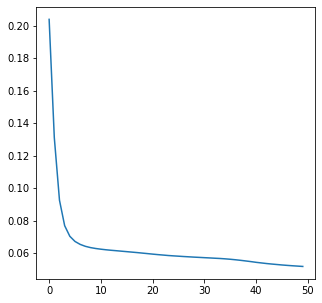

In [35]:
plt.plot(list(range(epochs)), losses)

Features learned during training looks like the below image. This will later be compared with our baseline model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


odict_keys(['enc_emb.0.weight', 'enc_emb.0.bias', 'enc_lb.0.weight', 'enc_lb.0.bias', 'dec_lb.0.weight', 'dec_lb.0.bias', 'dec_emb.0.weight', 'dec_emb.0.bias'])
torch.Size([10, 784])


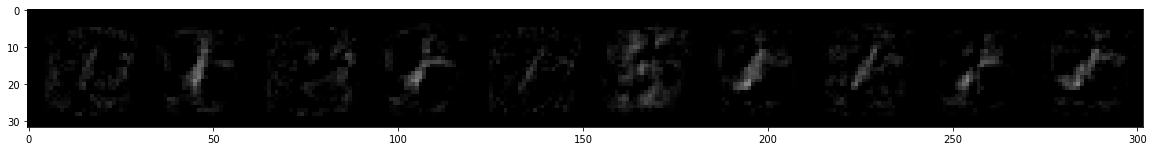

In [36]:
# visualization

plt.rcParams["figure.figsize"]=20, 20

print(model.state_dict().keys())
weight = model.state_dict()['enc_emb.0.weight']
print(weight.size())        # Shape 10 x 784
weight = weight.view(-1, 1, 28, 28)     # Change shape to conform arg shape of make_grid, B x C x W x H
plt.imshow(torchvision.utils.make_grid(weight, nrow=10).permute(1, 2, 0))
plt.rcParams["figure.figsize"]=5, 5
TLDA_weight = weight

## Evaluation

Evaluation process is simple. Since dataset is not skewed, we will simply compute the accuracy of prediction.

In [37]:
# classification
total_accuracy = 0
for batch_i, sampled_batch in enumerate(tgt_loader):
    imgs, lbs = sampled_batch
    _, _, _, _, pred = model(imgs, imgs)
    pred = torch.softmax(pred, 1)
    pred = pred.argmax(1)
    accuracy = (pred == lbs).sum() / pred.size()[0]
    total_accuracy += accuracy
total_accuracy = total_accuracy / num_batch
print(f"accuracy: {round(total_accuracy.item() * 100, 2)}%")


accuracy: 73.44%


## Baseline

We will compute DNN the same shaped as encoder side of TLDA. Likewise, we will evaluate the perfomance of transfer with checking how accurately the model predicts data from target domain with parameter taught in source domain.

In [38]:
# baseline
class DNN(nn.Module):
    def __init__(self, inp_sz, hdn_sz, cls_sz):
        super().__init__()
        self.lin1 = nn.Sequential(
            nn.Linear(inp_sz, hdn_sz),
            nn.Sigmoid()
        )
        self.lin2 = nn.Sequential(
            nn.Linear(hdn_sz, cls_sz),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 784)
        y = self.lin1(x)
        y = self.lin2(y)
        return y

# train
model = DNN(784, 10, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
epochs = 50

for epoch in range(epochs):
    total_loss = 0
    cur_time = time.time()
    for batch_i, sampled_batch in enumerate(src_loader):
        imgs, lbs = sampled_batch
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, lbs)
        loss.backward()
        optimizer.step()
        total_loss += loss
    if epoch % 5 == 4:
            print(f"epoch: {epoch + 1}\tloss: {round(total_loss.item() / num_batch, 4)},\ttime: {round(time.time() - cur_time, 4)}") 


total_accuracy = 0
for batch_i, sampled_batch in enumerate(tgt_loader):
    imgs, lbs = sampled_batch
    pred = model(imgs)
    pred = torch.softmax(pred, 1)
    pred = pred.argmax(1)
    accuracy = (pred == lbs).sum() / pred.size()[0]
    total_accuracy += accuracy
total_accuracy = total_accuracy / num_batch
print(f"accuracy: {round(total_accuracy.item() * 100, 2)}%")


epoch: 5	loss: 0.4197,	time: 0.1299
epoch: 10	loss: 0.3745,	time: 0.1354
epoch: 15	loss: 0.3601,	time: 0.1508
epoch: 20	loss: 0.3523,	time: 0.1273
epoch: 25	loss: 0.3472,	time: 0.1257
epoch: 30	loss: 0.3436,	time: 0.1543
epoch: 35	loss: 0.3404,	time: 0.1275
epoch: 40	loss: 0.3373,	time: 0.1304
epoch: 45	loss: 0.3343,	time: 0.1527
epoch: 50	loss: 0.3321,	time: 0.1241
accuracy: 48.65%


## Comparison

The accuracy for each model was __73.44% for TLDA while 47.3% for baseline__.

I find it iteresting the most when I get to see what computer sees.
I extracted hidden layers from each trained model (TLDA and baseline). What they see as features are very different as you see from the pictures below.
What I see is the features in TLDA is much more general than the features learned in the baseline.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


odict_keys(['lin1.0.weight', 'lin1.0.bias', 'lin2.0.weight', 'lin2.0.bias'])
torch.Size([10, 784])


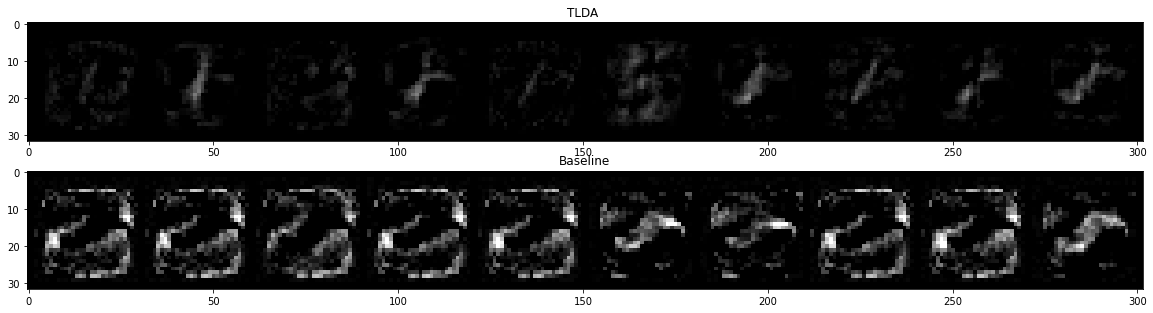

In [39]:
# visualization

plt.rcParams["figure.figsize"]=20, 5

print(model.state_dict().keys())
weight = model.state_dict()['lin1.0.weight']
print(weight.size())        # Shape 10 x 784
weight = weight.view(-1, 1, 28, 28)     # Change shape to conform arg shape of make_grid, B x C x W x H
plt.subplot(2, 1, 1)
plt.title("TLDA ")
plt.imshow(torchvision.utils.make_grid(TLDA_weight, nrow=10).permute(1, 2, 0))
plt.subplot(2, 1, 2)
plt.title("Baseline")
plt.imshow(torchvision.utils.make_grid(weight, nrow=10).permute(1, 2, 0))
plt.rcParams["figure.figsize"]=5, 5